In [1]:

from neurodsp.spectral import compute_spectrum
from neurodsp.utils import create_times
from neurodsp.plts.spectral import plot_power_spectra

import pingouin as pg
from fooof import FOOOFGroup
from natsort import natsorted

from os import listdir
from os.path import join
import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt

import seaborn as sns
import contextlib
import arviz as az
import pymc as pm
import aesara.tensor as at

import bambi as bmb
import sys
sys.path.append('/mnt/obob/staff/fschmidt/cardiac_1_f/')
from utils.fooof_utils import check_outliers, get_good_idx
from utils.psd_utils import interpolate_line_freq
from utils.plot_utils import plot_ridge
from utils.pymc_utils import coefficients2pcorrs

# all these imports are needed (for some fucking weird reason the toolbox throws an error otherwise)
import pyhrv
#import pyhrv.frequency_domain as fd
#import pyhrv.time_domain as td
#import pyhrv.tools as tools
#import biosppy

#%matplotlib inline
sns.set_style('ticks')
sns.set_context('poster')

import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

# use pyhrv standard settings (or at least what was suggested on the website)
settings_time = {
    'threshold': 50,            # Computation of NNXX/pNNXX with 50 ms threshold -> NN50 & pNN50
    'plot': False,               # If True, plots NNI histogram
    'binsize': 7.8125           # Binsize of the NNI histogram
    }

    # Frequency Domain Settings
settings_welch = {
    'nfft': 2 ** 12,            # Number of points computed for the FFT result
    'detrend': True,
    'show': False,
    'show_param': False, 
    'legend':False,           # If True, detrend NNI series by subtracting the mean NNI
    'window': 'hanning'         # Window function used for PSD estimation
    }

settings_lomb = {
        'nfft': 2**8, 
        'show': False,
        'show_param': False, 
        'legend':False,                 # Number of points computed for the Lomb PSD
        'ma_size': 5                # Moving average window size
    }

settings_ar = {
        'nfft': 2**12,
        'show': False,
        'show': False,
        'show_param': False, 
        'legend':False,                # Number of points computed for the AR PSD
        'order': 32                 # AR order
    }

    # Nonlinear Parameter Settings
settings_nonlinear = {
        'short': [4, 16],           # Interval limits of the short term fluctuations
        'long': [17, 64], 
        'legend':False,            # Interval limits of the long term fluctuations
        'dim': 2,                   # Sample entropy embedding dimension
        'tolerance': None           # Tolerance distance for which the vectors to be considered equal (None sets default values)
    }


brms_kwargs = {'draws': 2000,
               'tune': 2000,
               'chains': 4,
               'target_accept': 0.9,}

/mnt/obob/staff/fschmidt/conda_cache/envs/ml/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/mnt/obob/staff/fschmidt/conda_cache/envs/ml/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
DATA_DIR = '../data/data_ecg_only/'
FS = 1000
subject_info = pd.read_csv(join(DATA_DIR, 'subject-info.csv'))

all_files = natsorted(listdir(DATA_DIR))

all_data = np.array([file[:-4] for file in all_files if '.dat' in file])

In [3]:
#%%capture
psd_data, hrv_data = [], []
skip_hrv = True

for idx, data in enumerate(all_data):
    #idx, data = 0, all_data[0]
    print(f'Current file is: {idx}')

    data_record = wfdb.rdsamp(join(DATA_DIR, data))

    cur_data = data_record[0][:,0]
    times = create_times(len(data_record[0])/FS, FS)
    
    cur_data = cur_data[times < subject_info['Length'].min()*60]
    
    #Compute standard hrv data
    if skip_hrv == False:

        try:
            all_outputs = ['nni_counter', 'nni_mean', 'nni_min', 'nni_max', 'hr_mean', 'hr_min', 'hr_max',
                        'hr_std', 'nni_diff_mean','nni_diff_min', 'nni_diff_max', 'sdnn', 'sdnn_index', 'sdann',
                        'rmssd', 'sdsd', 'nn50','pnn50','nn20','pnn20', 'sd1', 'sd2', 'sd_ratio',
                        'ellipse_area', 'sampen', 'dfa_alpha1', 'dfa_alpha2', 'fft_ratio', 'fft_total']
            #Compute standard hrv data
            results = pyhrv.hrv(signal=cur_data,
                                kwargs_time=settings_time,
                                kwargs_welch=settings_welch,
                                kwargs_ar=settings_ar,
                                kwargs_lomb=settings_lomb,
                                kwargs_nonlinear=settings_nonlinear,
                                plot_ecg=False,
                                plot_tachogram=False,
                                show=False,
                                );
            cur_df = pd.DataFrame({output: results[output] for output in all_outputs}, index=[idx])
            cur_df['subject_id'] = idx

            #get frequency output
            freq_output = ['fft_peak', 'fft_abs', 'fft_rel', 'fft_log',
                        'lomb_peak', 'lomb_abs', 'lomb_rel', 'lomb_log',
                        'ar_peak', 'ar_abs', 'ar_rel', 'ar_log',]

            freq_dfs = []
            for f_out in freq_output:
                cur_res = results[f_out]
                freq_dfs.append(pd.DataFrame({f'vlf_{f_out}': cur_res[0],
                                              f'lf_{f_out}': cur_res[1],
                                              f'hf_{f_out}': cur_res[2]}, index=[0])) #index 0 is important here
            df_freq_cmb = pd.concat(freq_dfs, axis=1)
            df_freq_cmb['subject_id'] = idx

            cur_df_cmb = cur_df.merge(df_freq_cmb, on='subject_id')
                               
            hrv_data.append(cur_df_cmb)
     
        except ValueError:
            hrv_data.append(pd.DataFrame(dict(zip(all_outputs, np.ones(len(all_outputs)) * np.nan)), index=[idx]))

    nperseg = FS*10
    freq_med, psd_med = compute_spectrum(cur_data, FS, method='welch', avg_type='median', nperseg=nperseg, noverlap=nperseg/2) #
    psd_data.append(psd_med)

Current file is: 0
Current file is: 1
Current file is: 2
Current file is: 3
Current file is: 4
Current file is: 5
Current file is: 6
Current file is: 7
Current file is: 8
Current file is: 9
Current file is: 10
Current file is: 11
Current file is: 12
Current file is: 13
Current file is: 14
Current file is: 15
Current file is: 16
Current file is: 17
Current file is: 18
Current file is: 19
Current file is: 20
Current file is: 21
Current file is: 22
Current file is: 23
Current file is: 24
Current file is: 25
Current file is: 26
Current file is: 27
Current file is: 28
Current file is: 29
Current file is: 30
Current file is: 31
Current file is: 32
Current file is: 33
Current file is: 34
Current file is: 35
Current file is: 36
Current file is: 37
Current file is: 38
Current file is: 39
Current file is: 40
Current file is: 41
Current file is: 42
Current file is: 43
Current file is: 44
Current file is: 45
Current file is: 46
Current file is: 47
Current file is: 48
Current file is: 49
Current fi

In [5]:
#psd_new = [interpolate_line_freq(sub, line_freq=50, freqs=freq_med, n_hz_prior=2) for sub in psd_data]
#df_psd = pd.DataFrame(np.transpose(psd_new))

df_psd = pd.DataFrame(np.transpose(psd_data))
df_psd['Frequency (Hz)'] = freq_med
df_psd_tidy = df_psd.melt(id_vars='Frequency (Hz)')


psd2fooof = np.array(psd_data)
good_files = [~(np.isnan(file).sum() > 0) for file in psd2fooof] #only take spectra without nans
psd2fooof = psd2fooof[good_files]

#Get good idcs in subject info
good_idcs = [int(file) for file in np.array(all_data)[good_files]]
subject_info_clean = subject_info.loc[subject_info['ID'].isin(good_idcs)]

In [5]:
psd_d0 = np.array(psd_data)[good_files][subject_info_clean['Device'] == 0].mean(axis=0)
psd_d1 = np.array(psd_data)[good_files][subject_info_clean['Device'] == 1].mean(axis=0)

In [6]:
def read_process_meg_ecg_psd(path, knee):

    df_meg_psd = pd.read_csv(path)
    df_meg_psd_cut = df_meg_psd.query('channel == 0')
    df_meg_psd_cut = df_meg_psd_cut[['Frequency (Hz)', 'ECG Electrode', 'age', 'subject_id']]
    avg_psd2plot = df_meg_psd_cut.groupby('Frequency (Hz)').mean().reset_index()

    wide_meg_psd = df_meg_psd_cut.pivot(values='ECG Electrode', index='subject_id', columns='Frequency (Hz)')

    freqs_meg = wide_meg_psd.columns.to_numpy()
    psd2fooof_meg = wide_meg_psd.to_numpy()
    df_meg_age = df_meg_psd_cut.drop_duplicates(subset='subject_id')[['age', 'subject_id']].reset_index()


    exp_range = [45, 95, 145, 195]

    corr_meg, df_all_cmb_meg = [],[]

    for freq in exp_range:
        #Pretty obvious knee in the data
        #Yet fitting with a knee doesnt seem to change the age correlation -> rather improves it
        #fitting without a knee for now for comparability with the results from meg

        if knee:
            fg = FOOOFGroup(max_n_peaks=0, aperiodic_mode='knee')
        else:
            fg = FOOOFGroup(max_n_peaks=0)


        fg.fit(freqs_meg, psd2fooof_meg, freq_range=(0.5, freq), progress='tqdm')

        aps = pd.DataFrame(fg.get_params('aperiodic_params'))

        if knee:
            aps.columns = ['Offset', 'Knee', 'Exponent']
        else:
            aps.columns = ['Offset', 'Exponent']


        s_info_clean = df_meg_age.loc[get_good_idx(fg, thresh=2.5)].reset_index()
        aps_clean = aps.loc[get_good_idx(fg, thresh=2.5)].reset_index()

        
        df_cmb_meg = pd.concat([aps_clean, s_info_clean], axis=1)
        df_cmb_meg['fm_freq'] = freq
        df_all_cmb_meg.append(df_cmb_meg)

        corr_meg.append(pg.corr(df_cmb_meg['Exponent'], df_cmb_meg['age'])['r'])

    return corr_meg, df_all_cmb_meg, avg_psd2plot

corr_meg_sbg, df_all_cmb_meg_sbg, avg_psd2plot_sbg = read_process_meg_ecg_psd('../data/sbg_1_f_dataframe_1_145_psd.csv', knee=False)
corr_meg_cc, df_all_cmb_meg_cc, avg_psd2plot_cc = read_process_meg_ecg_psd('../data/cam_can_1_f_dataframe_1_145_psd.csv', knee=False)

corr_meg_sbg_k, df_all_cmb_meg_sbg_k, avg_psd2plot_sbg_k = read_process_meg_ecg_psd('../data/sbg_1_f_dataframe_1_145_psd.csv', knee=True)
corr_meg_cc_k, df_all_cmb_meg_cc_k, avg_psd2plot_cc_k = read_process_meg_ecg_psd('../data/cam_can_1_f_dataframe_1_145_psd.csv', knee=True)

Running FOOOFGroup:  13%|█▎        | 84/655 [00:00<00:01, 413.08it/s]


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



Running FOOOFGroup:  11%|█         | 69/655 [00:00<00:01, 343.57it/s]


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



Running FOOOFGroup:   9%|▉         | 59/655 [00:00<00:02, 293.11it/s]


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



Running FOOOFGroup:   9%|▊         | 57/655 [00:00<00:02, 280.51it/s]


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



Running FOOOFGroup:   8%|▊         | 53/627 [00:00<00:02, 226.64it/s]


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



Running FOOOFGroup:  11%|█         | 68/627 [00:00<00:01, 333.58it/s]


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



Running FOOOFGroup:  10%|▉         | 62/627 [00:00<00:01, 299.87it/s]


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



Running FOOOFGroup:   9%|▊         | 54/627 [00:00<00:02, 267.41it/s]


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



Running FOOOFGroup:   1%|          | 8/655 [00:00<00:18, 34.42it/s]


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



Running FOOOFGroup:   2%|▏         | 14/655 [00:00<00:10, 60.90it/s]


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



Running FOOOFGroup:   2%|▏         | 14/655 [00:00<00:10, 60.17it/s]


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



Running FOOOFGroup:   2%|▏         | 13/655 [00:00<00:10, 58.51it/s]


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



Running FOOOFGroup:   2%|▏         | 12/627 [00:00<00:15, 38.65it/s]


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



Running FOOOFGroup:   2%|▏         | 14/627 [00:00<00:09, 63.52it/s]


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



Running FOOOFGroup:   2%|▏         | 11/627 [00:00<00:11, 51.69it/s]


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



Running FOOOFGroup:   2%|▏         | 14/627 [00:00<00:10, 58.49it/s]


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



Running FOOOFGroup: 100%|██████████| 627/627 [00:10<00:00, 59.29it/s]


In [7]:
exps_cmb_150_meg_cc = pd.concat(df_all_cmb_meg_cc).query('fm_freq == 145')
exps_cmb_150_meg_sbg = pd.concat(df_all_cmb_meg_sbg).query('fm_freq == 145')

exps_cmb_150_meg_cc_k = pd.concat(df_all_cmb_meg_cc_k).query('fm_freq == 145')
exps_cmb_150_meg_sbg_k = pd.concat(df_all_cmb_meg_sbg_k).query('fm_freq == 145')

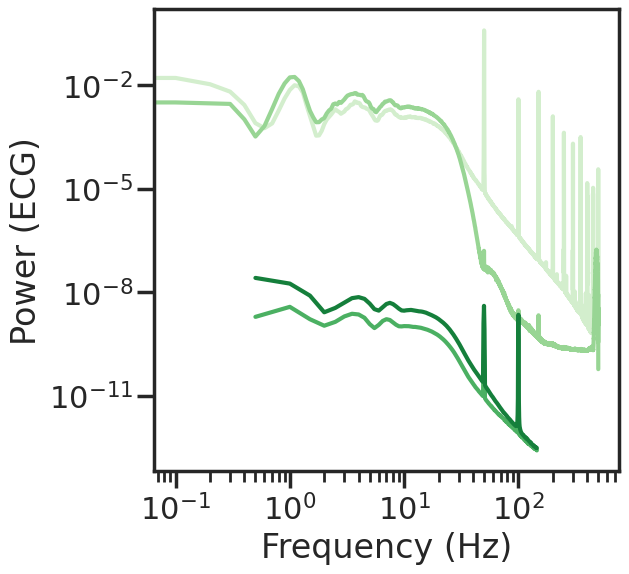

In [8]:
#Some clear powerline artefacts (removing this doesnt change results a lot)

fig, ax = plt.subplots()
ax.loglog(freq_med, psd_d0, color='#D3EECD');
ax.loglog(freq_med, psd_d1, color='#98D594');
ax.loglog(avg_psd2plot_cc['Frequency (Hz)'], avg_psd2plot_cc['ECG Electrode'], color='#4BB062')
ax.loglog(avg_psd2plot_sbg['Frequency (Hz)'], avg_psd2plot_sbg['ECG Electrode'], color='#157F3B')
ax.set_ylabel('Power (ECG)')
ax.set_xlabel('Frequency (Hz)')
fig.set_size_inches(6,6)
fig.savefig('../results/ga_ecg_psd.svg')

In [7]:
if skip_hrv == False:
    df_hrv = pd.concat(hrv_data)
    df_hrv.to_csv('hrv_data_ecg_only.csv')
else:
    df_hrv = pd.read_csv('../data/hrv_data_ecg_only.csv')

df_hrv_clean = df_hrv.loc[good_files]
good_idx_hrv = df_hrv['hr_mean'] > 20
(good_idx_hrv != good_files).sum()

0

In [11]:
def fit_fooof_range(knee):

    d_0_corr, d_1_corr, exps_list, df_all_cmb = [],[],[],[]

    exp_range = [2, 45, 95, 145, 195, 245, 295, 345, 395]

    #if knee:
    exp_range = exp_range[1:]

    for freq in exp_range:
        #Pretty obvious knee in the data
        #Yet fitting with a knee doesnt seem to change the age correlation -> rather improves it
        #fitting without a knee for now for comparability with the results from meg
        if knee:
            fg = FOOOFGroup(max_n_peaks=0, aperiodic_mode='knee')
        else:
            fg = FOOOFGroup(max_n_peaks=0)

        fg.fit(freq_med, psd2fooof, freq_range=(0.01, freq), progress='tqdm')

        aps = pd.DataFrame(fg.get_params('aperiodic_params'))

        if knee:
            aps.columns = ['Offset', 'Knee', 'Exponent'] #
        else:
            aps.columns = ['Offset', 'Exponent']
        exps_list.append(aps['Exponent'])

        s_info_clean = subject_info_clean.loc[get_good_idx(fg, thresh=2.5)].reset_index()
        aps_clean = aps.loc[get_good_idx(fg, thresh=2.5)].reset_index()
        df_hrv_clean2 = df_hrv_clean.loc[get_good_idx(fg, thresh=2.5)].reset_index()

        df_cmb = pd.concat([aps_clean, s_info_clean, df_hrv_clean2], axis=1)
        df_cmb['fm_freq'] = freq
        df_all_cmb.append(df_cmb)

        d_0 = df_cmb.query('Device == 0')
        d_1 = df_cmb.query('Device == 1')
        
        d_0_corr.append(pg.corr(d_0['Exponent'], d_0['Age_group'])['r'])
        d_1_corr.append(pg.corr(d_1['Exponent'], d_1['Age_group'])['r'])

    return  d_0_corr, d_1_corr, exps_list, df_all_cmb



In [12]:
d_0_corr, d_1_corr, exps_list, df_all_cmb = fit_fooof_range(knee=False)
d_0_corr_k, d_1_corr_k, exps_list_k, df_all_cmb_k = fit_fooof_range(knee=True)

Running FOOOFGroup: 100%|██████████| 1105/1105 [03:36<00:00,  5.11it/s]


In [12]:
exps_knee = pd.concat(df_all_cmb_k)[['fm_freq', 'Exponent', 'ID', 'Device']]
exps_no_knee = pd.concat(df_all_cmb)[['fm_freq', 'Exponent', 'ID', 'Device']]

exps_cmb = exps_knee.merge(exps_no_knee, on=['ID', 'fm_freq', 'Device'])

In [13]:
corr_list = []

for device in exps_knee['Device'].unique():
    for freq in exps_knee['fm_freq'].unique():
        corr_list.append(pg.corr(exps_cmb.query(f'fm_freq == {freq} and Device == {device}')['Exponent_x'],
                                 exps_cmb.query(f'fm_freq == {freq} and Device == {device}')['Exponent_y'],))

/tmp/ipykernel_7179/1369706579.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(freqs, rotation = 90)


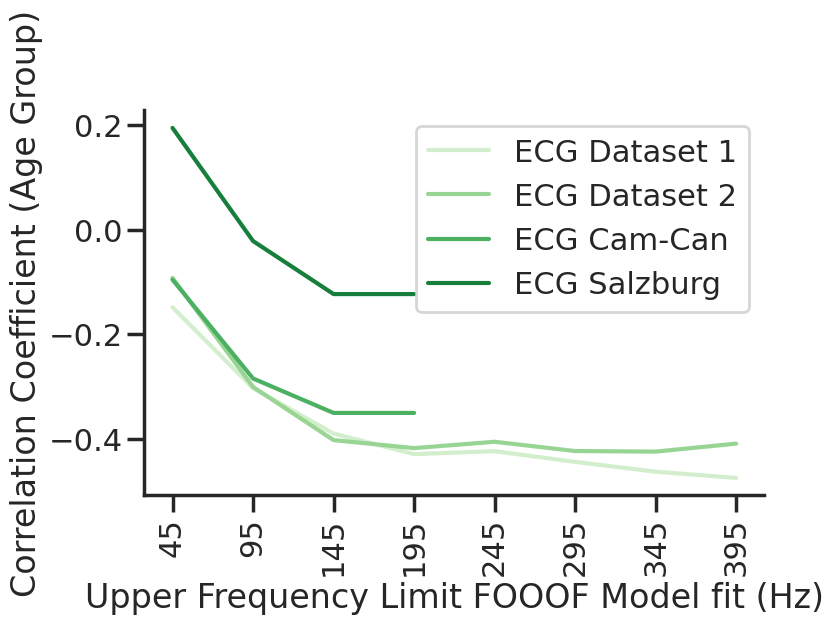

In [14]:
freqs = ['45', '95', '145', '195', '245', '295', '345', '395']
fig, ax = plt.subplots()
exp_range = ['45', '95', '145', '195',]
 
ax.plot(freqs, np.array(d_0_corr).flatten(), label='ECG Dataset 1', color='#D3EECD')
ax.plot(freqs, np.array(d_1_corr).flatten(), label='ECG Dataset 2', color='#98D594')
ax.plot(exp_range, np.array(corr_meg_cc).flatten(), label='ECG Cam-Can', color='#4BB062')
ax.plot(exp_range, np.array(corr_meg_sbg).flatten(), label='ECG Salzburg', color='#157F3B')
ax.set_ylabel('Correlation Coefficient (Age Group)')
ax.set_xlabel('Upper Frequency Limit FOOOF Model fit (Hz)')
ax.legend()
ax.set_xticklabels(freqs, rotation = 90)
fig.set_size_inches(8, 5)
sns.despine()
fig.savefig('../results/corr_age_freq_range_ecg_only_hf_no_knee.svg')

/tmp/ipykernel_3302/1896533965.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(freqs, rotation = 90)


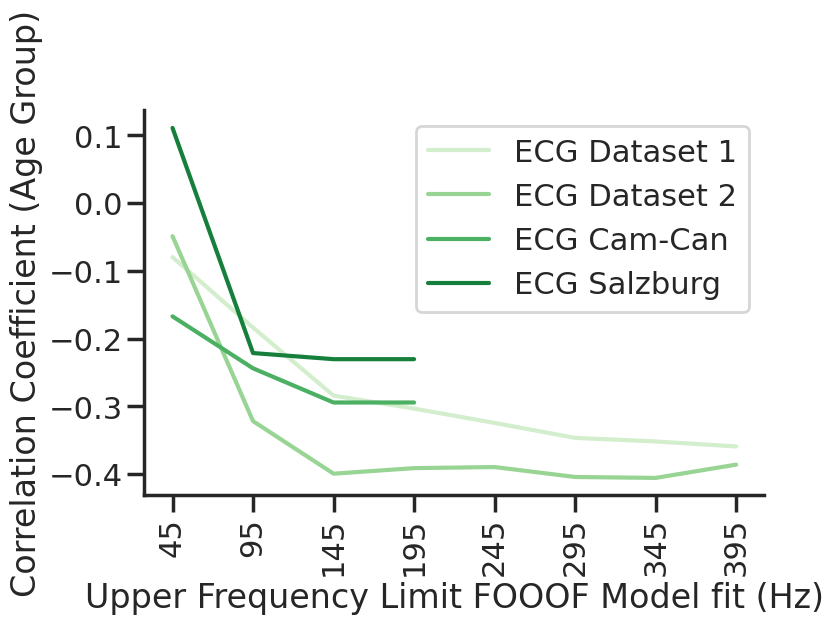

In [17]:
freqs = ['45', '95', '145', '195', '245', '295', '345', '395']
fig, ax = plt.subplots()
exp_range = ['45', '95', '145', '195',]
 
ax.plot(freqs, np.array(d_0_corr_k).flatten(), label='ECG Dataset 1', color='#D3EECD')
ax.plot(freqs, np.array(d_1_corr_k).flatten(), label='ECG Dataset 2', color='#98D594')
ax.plot(exp_range, np.array(corr_meg_cc_k).flatten(), label='ECG Cam-Can', color='#4BB062')
ax.plot(exp_range, np.array(corr_meg_sbg_k).flatten(), label='ECG Salzburg', color='#157F3B')
ax.set_ylabel('Correlation Coefficient (Age Group)')
ax.set_xlabel('Upper Frequency Limit FOOOF Model fit (Hz)')
ax.legend()
ax.set_xticklabels(freqs, rotation = 90)
fig.set_size_inches(8, 5)
sns.despine()
fig.savefig('../results/corr_age_freq_range_ecg_only_hf_knee.svg')

In [21]:
df_cmb_150 = pd.concat(df_all_cmb).query('fm_freq == 145')
df_cmb_150_k = pd.concat(df_all_cmb_k).query('fm_freq == 145')
df_cmb_150.dropna(inplace=True) #need to drop this now to save trouble in my bayesian models
df_cmb_150_k.dropna(inplace=True)


def add_age_groups(ecg_meg):

        #recode in age group to plot ecg from meg and ecg from other devices on the same scale

        #1 (18-19 years), 2 (20-24 years), 3 (25-29 years), 4 (30-34 years), 5 (35-39 years), 
        #6 (40-44 years), 7 (45-49 years), 8 (50-54 years), 9 (55-59 years), 10 (60-64 years), 
        #11 (65-69 years), 12 (70-74 years), 13 (75-79 years), 14 (80-84 years), 15 (85-92 years)
        #note this probably wont change the age corr a lot as a check precompute here


        #i hate recoding.. but necessary for figure

        #ag_list = [18, 19, 20, 24, 25, 29, 30, 34, 35, 39, 40, 44, 45, 49, 50, 54, 55, 59, 60, 64,
        # 65, 69, 70, 74, 75, 79, 80, 84, 85, 92]

        ag_list = [17, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 79, 84, 92]

        labels = np.arange(1, 16)
        ecg_meg['Age_group'] = pd.cut(ecg_meg['age'], bins=ag_list, labels=labels)

        return ecg_meg

#read meg data
def ecg_from_meg(path, device_n):

        ecg_meg = pd.read_csv(path).query('channel == 0')[['heart_slope', 'age', 'subject_id']]
        ecg_meg.reset_index(inplace=True)

        ecg_meg.drop(columns='index', inplace=True)
        ecg_meg.columns = ['Exponent', 'age', 'subject_id']
        ecg_meg['Device'] = device_n

        ecg_meg = add_age_groups(ecg_meg)

        return ecg_meg



exp_ecg_cam_can = ecg_from_meg('../data/cam_can_1_f_dataframe_1_145.csv', 3)
exp_ecg_sbg = ecg_from_meg('../data/sbg_1_f_dataframe_1_145.csv', 4)
#ecg_meg.drop(columns='age', inplace=True)

In [23]:
#there are probably better way of doing this, but i am too lazy to think right now
def format4expcorr(data, device_n, Knee):

    data['Device'] = device_n
    data['Knee'] = Knee

    exps = data[['Device', 'Knee', 'Exponent', 'subject_id']]

    return exps

df_cmb_150_k['Knee'] = True
df_cmb_150['Knee'] = False

all4knee_corr = pd.concat([df_cmb_150[['Device', 'Knee', 'Exponent', 'subject_id']],
                           df_cmb_150_k[['Device', 'Knee', 'Exponent', 'subject_id']],
                           format4expcorr(exps_cmb_150_meg_cc, 2, False),
                           format4expcorr(exps_cmb_150_meg_cc_k, 2, True),
                           format4expcorr(exps_cmb_150_meg_sbg, 3, False),
                           format4expcorr(exps_cmb_150_meg_sbg_k, 3, True),])

df4corr_knee = all4knee_corr.query('Knee == False')[['Device', 'Exponent', 'subject_id']].merge(all4knee_corr.query('Knee == True')[['Device', 'Exponent', 'subject_id']], on=['subject_id', 'Device'])

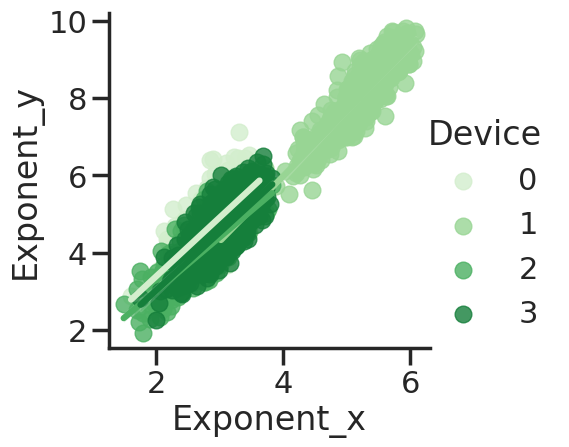

In [24]:
g = sns.lmplot(data=df4corr_knee, x='Exponent_x', y='Exponent_y', hue='Device', palette='Greens')

g.figure.savefig('../results/corr_knee_fixed_ecg.svg')

In [18]:
[np.corrcoef(df4corr_knee.query('Device == 0')['Exponent_x'], df4corr_knee.query('Device == 0')['Exponent_y'])[0,1],
np.corrcoef(df4corr_knee.query('Device == 1')['Exponent_x'], df4corr_knee.query('Device == 1')['Exponent_y'])[0,1],
np.corrcoef(df4corr_knee.query('Device == 2')['Exponent_x'], df4corr_knee.query('Device == 2')['Exponent_y'])[0,1],
np.corrcoef(df4corr_knee.query('Device == 3')['Exponent_x'], df4corr_knee.query('Device == 3')['Exponent_y'])[0,1]]

[0.7347129905861705,
 0.9115676887821582,
 0.8058570823812967,
 0.7428357872025123]

In [36]:
df4meg_plot = pd.concat(df_all_cmb).query('fm_freq == 145')[['Exponent', 'Age_group', 'Device']]
df4meg_plot_k = pd.concat(df_all_cmb_k).query('fm_freq == 145')[['Exponent', 'Age_group', 'Device']]

exps_cmb_150_meg_cc = add_age_groups(exps_cmb_150_meg_cc)
exps_cmb_150_meg_sbg = add_age_groups(exps_cmb_150_meg_sbg)
exps_cmb_150_meg_cc_k = add_age_groups(exps_cmb_150_meg_cc_k)
exps_cmb_150_meg_sbg_k = add_age_groups(exps_cmb_150_meg_sbg_k)

df2corr = pd.concat([df4meg_plot, exps_cmb_150_meg_cc[['Exponent', 'Age_group', 'Device']], exps_cmb_150_meg_sbg[['Exponent', 'Age_group', 'Device']]])

df2corr_k = pd.concat([df4meg_plot_k, exps_cmb_150_meg_cc_k[['Exponent', 'Age_group', 'Device']], exps_cmb_150_meg_sbg_k[['Exponent', 'Age_group', 'Device']]])

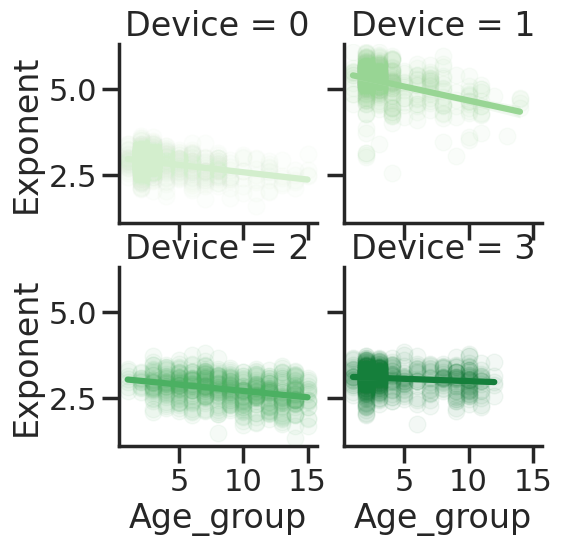

In [26]:
g = sns.lmplot(data=df2corr, x='Age_group', y='Exponent', hue='Device', palette='Greens', 
                col='Device', col_wrap=2,
                scatter_kws={'alpha': 0.05})

g.figure.set_size_inches(5, 5, forward=True)
g.figure.savefig('../results/ecg_only_age.svg')

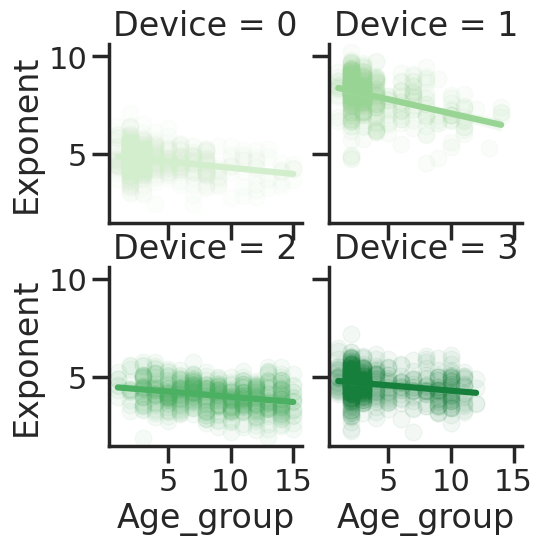

In [37]:
g = sns.lmplot(data=df2corr_k, x='Age_group', y='Exponent', hue='Device', palette='Greens', 
                col='Device', col_wrap=2,
                scatter_kws={'alpha': 0.05})

g.figure.set_size_inches(5, 5, forward=True)
g.figure.savefig('../results/ecg_only_age_k.svg')

In [29]:
d_04baycor = df2corr.query('Device == 0')[['Exponent', 'Age_group']].copy().dropna()
d_14baycor = df2corr.query('Device == 1')[['Exponent', 'Age_group']].copy().dropna()
d_24baycor = df2corr.query('Device == 2')[['Exponent', 'Age_group']].copy().dropna()
d_34baycor = df2corr.query('Device == 3')[['Exponent', 'Age_group']].copy().dropna()

In [30]:
#Calculate bayesian correlation
def baycor(data):
    with pm.Model() as correlation_model:

        # set some more or less informative priors here
        mu_exp = pm.Normal('mu_exp', mu=0, sigma=10.) #
        mu_age = pm.Normal('mu_age', mu=0, sigma=10.) # age is coded in groups here: think about whether a normal really makes sense here

        #prior on correlation
        chol, corr, stds = pm.LKJCholeskyCov("chol", n=2, eta=4.0, 
                   sd_dist=pm.HalfCauchy.dist(2.5), compute_corr=True)

        #stack data together
        mu = at.stack((mu_exp, mu_age), axis=1)
    
        #observed data
        y = pm.MvNormal('y', mu=mu, chol=chol, observed=data)

        trace = pm.sample(**brms_kwargs)
    return trace


trace_d0 = baycor(d_04baycor)    
trace_d1 = baycor(d_14baycor)    
trace_d2 = baycor(d_24baycor) 
trace_d3 = baycor(d_34baycor) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [mu_exp, mu_age, chol]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 129 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [mu_exp, mu_age, chol]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 112 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [mu_exp, mu_age, chol]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 116 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [mu_exp, mu_age, chol]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 109 seconds.


In [31]:
az.summary(trace_d0)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_exp,2.834,0.014,2.809,2.861,0.000,0.000,7336.0,6732.0,1.0
mu_age,4.086,0.127,3.859,4.334,0.001,0.001,7418.0,6027.0,1.0
chol[0],0.329,0.010,0.311,0.348,0.000,0.000,7397.0,5811.0,1.0
chol[1],-1.164,0.122,-1.400,-0.941,0.001,0.001,7263.0,6441.0,1.0
chol[2],2.786,0.084,2.635,2.948,0.001,0.001,8170.0,6571.0,1.0
"chol_corr[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,8000.0,8000.0,NaN
"chol_corr[0, 1]",-0.385,0.036,-0.454,-0.319,0.000,0.000,7627.0,6225.0,1.0
"chol_corr[1, 0]",-0.385,0.036,-0.454,-0.319,0.000,0.000,7627.0,6225.0,1.0
"chol_corr[1, 1]",1.000,0.000,1.000,1.000,0.000,0.000,7687.0,7481.0,1.0
chol_stds[0],0.329,0.010,0.311,0.348,0.000,0.000,7397.0,5811.0,1.0


In [32]:
az.summary(trace_d1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_exp,5.173,0.024,5.128,5.215,0.000,0.000,7029.0,6246.0,1.0
mu_age,3.756,0.116,3.539,3.974,0.001,0.001,7290.0,6285.0,1.0
chol[0],0.524,0.017,0.494,0.556,0.000,0.000,7895.0,6020.0,1.0
chol[1],-1.035,0.110,-1.246,-0.833,0.001,0.001,7725.0,5964.0,1.0
chol[2],2.386,0.076,2.246,2.529,0.001,0.001,7848.0,5218.0,1.0
"chol_corr[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,8000.0,8000.0,NaN
"chol_corr[0, 1]",-0.397,0.037,-0.463,-0.324,0.000,0.000,7793.0,6283.0,1.0
"chol_corr[1, 0]",-0.397,0.037,-0.463,-0.324,0.000,0.000,7793.0,6283.0,1.0
"chol_corr[1, 1]",1.000,0.000,1.000,1.000,0.000,0.000,7799.0,7722.0,1.0
chol_stds[0],0.524,0.017,0.494,0.556,0.000,0.000,7895.0,6020.0,1.0


In [33]:
az.summary(trace_d2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_exp,2.756,0.016,2.727,2.786,0.000,0.000,6600.0,5433.0,1.0
mu_age,8.596,0.149,8.315,8.874,0.002,0.001,7034.0,6515.0,1.0
chol[0],0.386,0.011,0.365,0.407,0.000,0.000,7590.0,6061.0,1.0
chol[1],-1.278,0.144,-1.563,-1.025,0.002,0.001,7449.0,5897.0,1.0
chol[2],3.449,0.100,3.257,3.630,0.001,0.001,8369.0,6305.0,1.0
"chol_corr[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,8000.0,8000.0,NaN
"chol_corr[0, 1]",-0.347,0.036,-0.412,-0.279,0.000,0.000,7744.0,5901.0,1.0
"chol_corr[1, 0]",-0.347,0.036,-0.412,-0.279,0.000,0.000,7744.0,5901.0,1.0
"chol_corr[1, 1]",1.000,0.000,1.000,1.000,0.000,0.000,7917.0,8000.0,1.0
chol_stds[0],0.386,0.011,0.365,0.407,0.000,0.000,7590.0,6061.0,1.0


In [34]:
az.summary(trace_d3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_exp,3.068,0.013,3.043,3.092,0.000,0.000,9543.0,6524.0,1.0
mu_age,4.214,0.120,3.990,4.441,0.001,0.001,8374.0,6099.0,1.0
chol[0],0.330,0.009,0.313,0.348,0.000,0.000,9393.0,6083.0,1.0
chol[1],-0.362,0.119,-0.578,-0.134,0.001,0.001,9096.0,6239.0,1.0
chol[2],2.978,0.084,2.823,3.138,0.001,0.001,8629.0,6200.0,1.0
"chol_corr[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,8000.0,8000.0,NaN
"chol_corr[0, 1]",-0.121,0.039,-0.191,-0.045,0.000,0.000,9065.0,6238.0,1.0
"chol_corr[1, 0]",-0.121,0.039,-0.191,-0.045,0.000,0.000,9065.0,6238.0,1.0
"chol_corr[1, 1]",1.000,0.000,1.000,1.000,0.000,0.000,7306.0,7661.0,1.0
chol_stds[0],0.330,0.009,0.313,0.348,0.000,0.000,9393.0,6083.0,1.0


In [57]:
#ecg data recorded at the meg were online filtered at 0.1hz 
#therefore frequency based power analysis in the very low bands investigated in the ecg community are not possibly. dropped at that stage
df2baycor_0 = df_cmb_150.query('Device == 0')
df2baycor_1 = df_cmb_150.query('Device == 1')


#drop(drop_list, axis=1, inplace=True)
#df2baycor_1.drop(drop_list, axis=1, inplace=True)

query_list = ['Exponent', 'hr_mean', 'hr_min', 'hr_max', 'hr_std' , 'vlf_fft_log', 'lf_fft_log', 'hf_fft_log', 'pnn20', 'pnn50']
df2baycor_0 = df2baycor_0[query_list]
df2baycor_1 = df2baycor_1[query_list]

relabel_list_heart = ['Exponent',  'Heart Rate (mean)', 'Heart Rate (min)', 'Heart Rate (max)', 'Heart Rate (std)',
                      'VLF (0 - 0.04Hz)', 'LF (0.04 - 0.15Hz)', 'HF (0.15 - 0.4Hz)', 'NN-Interval > 20ms (ratio)', 'NN-Interval > 50ms (ratio)']

df2baycor_0.columns = relabel_list_heart
df2baycor_1.columns = relabel_list_heart

In [58]:
def corr_across_heart(data):

    coords = {'vars': list(data.keys())}

    with pm.Model(coords=coords) as correlation_model:
        #channel_num = pm.Data('channel_num', df2baycor.columns, dims='channel', mutable=False)

        # set some more or less informative priors here
        mu = pm.Normal('mu', mu=0, sigma=5., dims='vars') #

        #prior on correlation
        chol, corr, stds = pm.LKJCholeskyCov("chol", n=len(data.columns), eta=4.0, 
                    sd_dist=pm.HalfCauchy.dist(2.5), compute_corr=True)
        
        #observed data
        y = pm.MvNormal('y', mu=mu, chol=chol, observed=data)

        trace = pm.sample(**brms_kwargs)

    return trace

In [94]:
#Calculate bayesian correlation
from scipy.stats import zscore

df2baycor_0z = zscore(df2baycor_0, axis=0) #need to zscore to prevent sampling issues
df2baycor_1z = zscore(df2baycor_1, axis=0)

In [60]:
trace_0 = corr_across_heart(df2baycor_0z)
trace_1 = corr_across_heart(df2baycor_1z)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [mu, chol]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3128 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [mu, chol]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1854 seconds.


In [61]:
az.to_netcdf(trace_0, '../results/trace_0_corr_ecg.ncdf')
az.to_netcdf(trace_1, '../results/trace_1_corr_ecg.ncdf')

'../results/trace_1_corr_ecg.ncdf'

In [81]:
def cmb_corr_trace(traces):


    df_list = []
    for idx, trace in enumerate(traces):
        shapes = trace.posterior['chol_corr'].shape
        shape_dim_0 = shapes[0] * shapes[1]
        df_trace = pd.DataFrame(trace.posterior['chol_corr'][:,:,:,0].to_numpy().reshape(shape_dim_0, 10))
        df_trace.columns = relabel_list_heart
        df_trace.drop(columns='Exponent',  inplace=True) #drop self correlations
        tidy_trace = df_trace.melt()
        tidy_trace.columns = ['feature', 'correlation_coefficient']
        tidy_trace['dataset'] = idx
        df_list.append(tidy_trace)
    
    df_cmb = pd.concat(df_list)
    df_cmb.reset_index(inplace=True)

    return df_cmb

In [82]:
trace_0 = az.from_netcdf('../results/trace_0_corr_ecg.ncdf')
trace_1 = az.from_netcdf('../results/trace_1_corr_ecg.ncdf')

df_exp_corr = cmb_corr_trace([trace_0, trace_1])

/mnt/obob/staff/fschmidt/conda_cache/envs/ml/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/mnt/obob/staff/fschmidt/conda_cache/envs/ml/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/mnt/obob/staff/fschmidt/conda_cache/envs/ml/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/mnt/obob/staff/fschmidt/conda_cache/envs/ml/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommo

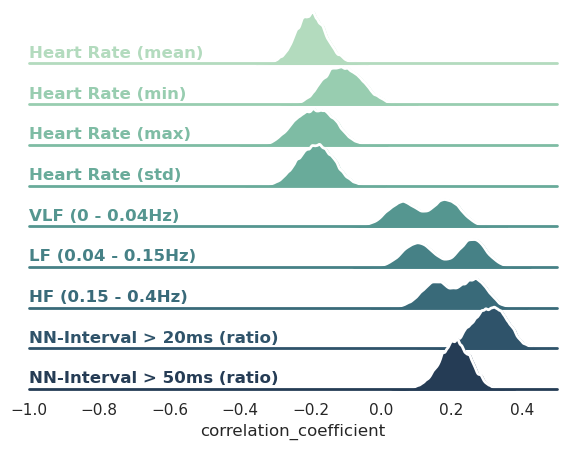

In [93]:
pal = sns.cubehelix_palette(10, rot=-.4, light=.8)

g = plot_ridge(df_exp_corr, 'feature', 'correlation_coefficient', 
           pal=pal, aspect=12, xlim=(-1, 0.5))

g.figure.savefig('../results/1_f_exp_corr_ridge.svg')